Objectif R2 max

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style('whitegrid')

In [10]:
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]

In [11]:
data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)

In [12]:
# Features & Target
X = data.drop(columns="CF")
y = data["CF"]

#ajout d'un lag
X_days_TP = X["TP"].rolling(window=7, min_periods=1).sum()
X_days_TA = X["TA"].rolling(window=60, min_periods=1).mean()

X2 = pd.concat([X_days_TP, X_days_TA ], axis = 1)

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

results = {"Actual": y_test}

In [13]:
def display_result(y_true, y_pred):
    """Affiche les résultats de prédiction / réels."""
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")

    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, color="tab:blue", s=10)

    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_ylim(lb, ub)
    ax2.set_xlim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    plt.show()

In [14]:
def display_result_season(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

R2: 0.434032
MSE: 0.006106



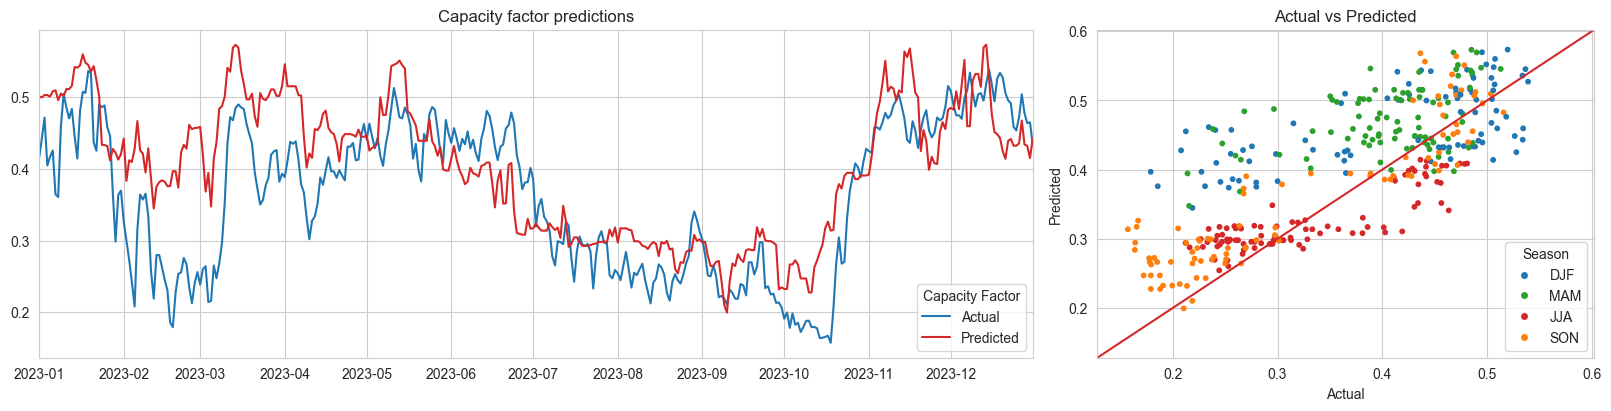

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Modèle Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=300,   # nombre d’étapes de boosting
    learning_rate=0.05, # vitesse d'apprentissage
    max_depth=3,        # profondeur des arbres faibles
    random_state=42
)

# Entraînement
gbr.fit(X_train, y_train)

# Prédictions
y_pred = gbr.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

# Ajout dans results
results["GBR"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

# Affichage personnalisé (même que ton code)
display_result_season(y_test, y_pred)